## **Restaurant Recommendation Based on Specific Dish of American Cuisine**

In this task, our goal is to recommend good restaurants to those who would like to try one or more dishes in a cuisine. In this case, we will work on American (New) Cuisine

Given a particular dish, the general idea of solving this problem is to assess whether a restaurant is good for this dish based on whether the reviews of a candidate restaurant have included many positive (and very few negative) comments about the dish.

Something to consider is to make our visualization general enough such that it could be used in a search engine or system and generate something useful for the users by recommending popular restaurants based on different dishes.

In [2]:
import json
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import re

In [3]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define the file path and target category
business_file_path = '/content/drive/MyDrive/Data Mining Project UIUC/dataset/yelp_academic_dataset_business.json'
target_category = 'American (New)'

# Function to filter businesses by category and extract their names and business IDs
def filter_business_info_by_category(file_path, target_category):
    business_info = []

    # Open and read the JSON file line by line
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            business = json.loads(line)
            # Check if the target category is in the list of categories for this business
            if target_category in business.get('categories', ''):
                # Append a tuple of (business ID, name) to the list
                business_info.append((business['business_id'], business['name']))

    return business_info

american_business_info = filter_business_info_by_category(business_file_path, target_category)
american_business_ids, american_business_names = zip(*american_business_info)

# Calculate the number of total and unique restaurant names
total_businesses = len(american_business_names)
unique_restaurants = len(set(american_business_names))

# Display the results
print(f"Number of businesses (including branches) with category '{target_category}': {total_businesses}")
print(f"Number of unique restaurants with category '{target_category}': {unique_restaurants}")

Number of businesses (including branches) with category 'American (New)': 1058
Number of unique restaurants with category 'American (New)': 914


From this data, we know that some restaurants have franchises or branches with 914 of restaurants brand while 1058 restaurants are calculated based on `business_id`. Now let's identify whether these restaurants are unique to each other.

In [5]:
# Generator to read large JSON file line by line
def json_reader(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            yield json.loads(line)

#Filter business details while reading line by line
filtered_business_list = []
for business in json_reader(business_file_path):
    if business['business_id'] in american_business_ids:
        filtered_business_list.append({
            'business_id': business['business_id'],
            'name': business['name'],
            'state': business['state'],
            'address': business.get('full_address', ''),  # Use .get() to handle missing addresses
            'review_count': business.get('review_count', 0)  # Handle missing review count
        })

# Convert the list to a DataFrame
filtered_businesses = pd.DataFrame(filtered_business_list)

In [6]:
# Function to reformat the address using regex
def reformat_address(address):
    # Replace '\n' with ', ' to handle multiple newlines
    address = address.replace('\n', ', ')

    # Define regex pattern to match the address components
    pattern = r'^(.*)\n(.*),\s*([A-Z]{2})\s*(\d{5})$'
    match = re.match(pattern, address)

    if match:
        street, city, state, zip_code = match.groups()
        # Return the reformatted address
        return f"{street}, {city}, {state} {zip_code}"
    else:
        # Return the original address if it doesn't match the pattern
        return address

# Apply the reformat_address function to the 'address' column
filtered_businesses['address'] = filtered_businesses['address'].apply(reformat_address)
filtered_businesses.head()

,business_id,name,state,address,review_count
0,HaBkx5PwvbBpQ2iNCgHnVQ,Paul's Neighborhood Bar,WI,"2401 Parmenter St, Middleton, WI 53562",11
1,Nj0vQjUYjaa7qbvZlEr2jQ,Club Tavern & Grille,WI,"1915 Branch St, Middleton, WI 53562",16
2,yYIEKwgQUHJpySOcVdCAkg,Perkins Restaurant & Bakery,WI,"4863 Hayes Rd, Bluff Acres, Madison, WI 53704",8
3,11yg-JMNCFowyIjJarzuDQ,Hardee's,WI,"4814 Annamark Dr, Madison, WI 53704",5
4,oudTF4EN_C8thENGiTQf-w,Chili's,WI,"4344 E Towne Blvd, Madison, WI 53704",9


Now that we've got the DataFrame of filtered restaurants, the next steps are:

- Get Reviews and Average Rating for Each Restaurant: Retrieve the reviews and compute the average rating for each restaurant.
- Find Restaurants Mentioning 'Burger': Filter reviews to find restaurants where "burger" is mentioned and calculate the average rating for those specific reviews.

In [7]:
# Group by restaurant name and count the number of unique business IDs for each name
duplicate_restaurants = filtered_businesses.groupby('name').agg(
    unique_business_ids=pd.NamedAgg(column='business_id', aggfunc='nunique'),
    all_business_ids=pd.NamedAgg(column='business_id', aggfunc=lambda x: list(x)),
    all_states=pd.NamedAgg(column='state', aggfunc=lambda x: list(x)),
    all_address=pd.NamedAgg(column='address', aggfunc=lambda x: list(x))
).reset_index()

# Filter to keep only restaurants that have more than one unique business ID
duplicate_restaurants = duplicate_restaurants[duplicate_restaurants['unique_business_ids'] > 1]
duplicate_restaurants

,name,unique_business_ids,all_business_ids,all_states,all_address
42,Applebee's Neighborhood Grill & Bar,2,"[ZusZ0l8gBpLvvYcTkuvRgw, smoGuW2a2Nume83mB3JJSw]","[WI, NV]","[660 S Whitney Way, Madison, WI 53711, 820 E W..."
44,Arcadia Farms Cafe,2,"[24V8QQWO6VaVggHdxjQQ_A, 3EEVGDngt4DEhoOQZIUNUw]","[AZ, AZ]","[7014 E 1st Ave, Scottsdale, AZ 85251, 1625 N ..."
55,BJ's Restaurant & Brewhouse,7,"[IMGW6y8wHQCfr_6k-YXg_A, zORdAIouXrGO1yU4sIMwe...","[AZ, NV, AZ, AZ, NV, AZ, NV]","[3155 W.Chandler Blvd., Chandler, AZ 85226, 10..."
101,Blu Burger Grille,2,"[zuso11YrG2rewOtSFr4aCw, QEGx_9YMYzu_IOLaFz7arQ]","[AZ, AZ]","[23233 N Pima Rd, Scottsdale, AZ 85255, 7366 E..."
140,Cafe Zupas,2,"[CMaJOgyFrX6gVsJGm1bttw, MkQz_wPoaELPVy6Hwwf7Ug]","[AZ, AZ]","[21001 N Tatum Blvd, Ste 34-110, Phoenix, AZ 8..."
146,California Pizza Kitchen,9,"[ut-kla-EA23nJOij_dcL0Q, UpYva_zhJ6pRGfdTruIYI...","[AZ, AZ, AZ, AZ, NV, NV, AZ, AZ, NV]","[2400 E. Camelback Rd, Ste. 112, Phoenix, AZ 8..."
147,Calistro California Bistro,2,"[EBwv1DBGKsfdNZEYL70Dqw, shpgZ07M-IBDwjz2cpjWiA]","[AZ, AZ]","[18221 N Pima Rd, Scottsdale, AZ 85255, 6107 N..."
170,Cheddar's,2,"[oly8HWl0MtuioFWKPINIFg, huSYFgKj79uaZSerXcltZQ]","[AZ, AZ]","[2530 W Chandler Blvd, Chandler, AZ 85224, 253..."
177,Chick-Fil-A,2,"[ZHPRAv3k2q662Q8Qj6zByg, XiCnbGY6R92Ji7r38jceZA]","[AZ, AZ]","[5035 E Ray Rd, Phoenix, AZ 85044, 1601 E Came..."
178,Chick-fil-A,2,"[DAIBZ-I6i5wEUsxEolzXBA, C51teWZIJIEGVYFTijaw_w]","[AZ, AZ]","[16657 N 83rd Ave, Peoria, AZ 85382, 905 N Dob..."


Based on the duplicate data above, we found that these restaurants are identical, because they have different adress. So, for the next preprocessing, we will do the visualization and restaurant recommendation separately, where for the visualization we will do accumulative review and average rating for restaurant brand while for the recommendation we will do for the specific restaurant.

In [8]:
duplicate_restaurants.to_csv('Duplicate_Restaurants.csv')

## **1. Restaurant Recommendation**

In [9]:
# REview file path
reviews_file_path = '/content/drive/MyDrive/Data Mining Project UIUC/dataset/yelp_academic_dataset_review.json'
filtered_reviews_list = []

# Read reviews for relevant business IDs
for review in json_reader(reviews_file_path):
    if review['business_id'] in filtered_businesses['business_id'].values:
        filtered_reviews_list.append({
            'business_id': review['business_id'],
            'text': review['text'],
            'stars': review['stars']
        })
filtered_reviews_df = pd.DataFrame(filtered_reviews_list)

In [10]:
filtered_reviews_df

,business_id,text,stars
0,HaBkx5PwvbBpQ2iNCgHnVQ,May be one of Middleton's best kept secrets......,4
1,HaBkx5PwvbBpQ2iNCgHnVQ,This is a local bar and not a fine dining rest...,3
2,HaBkx5PwvbBpQ2iNCgHnVQ,"If your looking for bar food, that is what you...",3
3,HaBkx5PwvbBpQ2iNCgHnVQ,All you can eat fish fry for $11.75! Of course...,4
4,HaBkx5PwvbBpQ2iNCgHnVQ,It delivers on the name. I stopped in after wo...,2
...,...,...,...
94178,OEUIE8VBa1BbBfr5EPcTOA,Barely open less than a week and I've been her...,4
94179,OEUIE8VBa1BbBfr5EPcTOA,Healthy Food that Keeps this Realtor on the Go...,5
94180,OEUIE8VBa1BbBfr5EPcTOA,So happy to have this healthy eatery option ri...,5
94181,OEUIE8VBa1BbBfr5EPcTOA,Always been huge fan ever since the first Pres...,5


In [11]:
# Compute average rating
filtered_reviews_df['weighted_rating'] = filtered_reviews_df['stars']

grouped_ratings = filtered_reviews_df.groupby('business_id').agg(
    total_weighted_rating=pd.NamedAgg(column='weighted_rating', aggfunc='sum'),
    total_reviews=pd.NamedAgg(column='stars', aggfunc='count')
).reset_index()

grouped_ratings['average_rating'] = round(grouped_ratings['total_weighted_rating'] / grouped_ratings['total_reviews'], 2)
df_all_restaurant = pd.merge(filtered_businesses, grouped_ratings[['business_id', 'average_rating']], on='business_id', how='inner')

In [12]:
df_all_restaurant

,business_id,name,state,address,review_count,average_rating
0,HaBkx5PwvbBpQ2iNCgHnVQ,Paul's Neighborhood Bar,WI,"2401 Parmenter St, Middleton, WI 53562",11,3.60
1,Nj0vQjUYjaa7qbvZlEr2jQ,Club Tavern & Grille,WI,"1915 Branch St, Middleton, WI 53562",16,2.50
2,yYIEKwgQUHJpySOcVdCAkg,Perkins Restaurant & Bakery,WI,"4863 Hayes Rd, Bluff Acres, Madison, WI 53704",8,2.62
3,11yg-JMNCFowyIjJarzuDQ,Hardee's,WI,"4814 Annamark Dr, Madison, WI 53704",5,3.75
4,oudTF4EN_C8thENGiTQf-w,Chili's,WI,"4344 E Towne Blvd, Madison, WI 53704",9,3.12
...,...,...,...,...,...,...
1053,HzQ2B6p8OuHOtYnXPqvd8w,The Vig McCormick Ranch,AZ,"7345 N Via Paseo Del Sur, Scottsdale, AZ 85258",26,4.07
1054,LsKF7GFQ0j5U1jLMwq0_hQ,Oven and Vine,AZ,"14 W Vernon Ave, Phoenix, AZ 85003",11,5.00
1055,fmfiSDAJtjxbnRBBtYhnNw,MACS,WI,"2804 Prairie Lakes Dr, Ste 106, Sun Prairie, W...",7,3.80
1056,ZpB2O-WAbbRHdP0V8GrwXA,LYFE Kitchen,NV,"140 S Green Valley Pkwy, Ste 142, Henderson, N...",34,3.35


In [13]:
df_all_restaurant.to_csv('American_Cuisine_Business_With_Rating.csv')

In [14]:
top_american_restaurant = df_all_restaurant.sort_values(by=['average_rating', 'review_count'], ascending=False).head(20)
top_american_restaurant

,business_id,name,state,address,review_count,average_rating
1054,LsKF7GFQ0j5U1jLMwq0_hQ,Oven and Vine,AZ,"14 W Vernon Ave, Phoenix, AZ 85003",11,5.00
935,uXJbNkU6cKAooMWTWnl5aA,Body Food Kitchen,NV,"Summerlin, Las Vegas, NV 89128",8,5.00
801,Vn438iBACx-giGy4E4SuFQ,Goto Pares Atbp,NV,"1428 E Charleston Ave, Downtown, Las Vegas, NV...",4,5.00
950,T4NYpm-fLUmSKa10pPpi8g,Jimmy John's,NV,"2450 Windmill Ln, Henderson, NV 89074",4,5.00
1008,l74kl8xTQN-Bx6rXbOPAVw,Joey's Tavern,NV,"7081 W Craig Rd, Northwest, Las Vegas, NV 89129",4,5.00
393,mOXrStaa4BOvFP6SgPo_Yg,Life Cafe,AZ,"Lifetime Fitness, 6850 E Chauncey Ln, Scottsda...",3,5.00
504,FNRimJN6wz2Bywuz4RV_TA,Old Market Bistro,WI,"15 N Butler St, Capitol, Madison, WI 53703",3,5.00
541,SVSNsGZat2WjTBNCmJlsHA,Ed's,AZ,"Phoenix, AZ 85004",3,5.00
772,xY5BFKQFo5iLDhXxihkduQ,Pollo Sabroso,AZ,"1602 E Jefferson St, Phoenix, AZ 85034",3,5.00
898,5ALqZbLAonfCRZMY-X_MyQ,Mayo Clinic Hospital Cafeteria,AZ,"5777 E Mayo Blvd, Phoenix, AZ 85054",10,4.88


In [15]:
# Filter reviews that mention "burger"
burger_reviews_df = filtered_reviews_df[filtered_reviews_df['text'].str.contains('burger', case=False, na=False)]

# Calculate the average rating for each restaurant based only on "Burger" mentions
burger_ratings_df = burger_reviews_df.groupby('business_id').agg(
    burger_total_stars=pd.NamedAgg(column='stars', aggfunc='sum'),
    burger_total_reviews=pd.NamedAgg(column='stars', aggfunc='count')
).reset_index()

# Compute the average rating for "Burger" mentions
burger_ratings_df['burger_average_rating'] = round(burger_ratings_df['burger_total_stars'] / burger_ratings_df['burger_total_reviews'], 2)
final_df_with_burger = pd.merge(filtered_businesses, burger_ratings_df[['business_id', 'burger_total_reviews', 'burger_average_rating']], on='business_id', how='inner')

In [16]:
final_df_with_burger

,business_id,name,state,address,review_count,burger_total_reviews,burger_average_rating
0,HaBkx5PwvbBpQ2iNCgHnVQ,Paul's Neighborhood Bar,WI,"2401 Parmenter St, Middleton, WI 53562",11,3,3.67
1,Nj0vQjUYjaa7qbvZlEr2jQ,Club Tavern & Grille,WI,"1915 Branch St, Middleton, WI 53562",16,2,4.00
2,yYIEKwgQUHJpySOcVdCAkg,Perkins Restaurant & Bakery,WI,"4863 Hayes Rd, Bluff Acres, Madison, WI 53704",8,1,4.00
3,11yg-JMNCFowyIjJarzuDQ,Hardee's,WI,"4814 Annamark Dr, Madison, WI 53704",5,2,4.00
4,oudTF4EN_C8thENGiTQf-w,Chili's,WI,"4344 E Towne Blvd, Madison, WI 53704",9,1,3.00
...,...,...,...,...,...,...,...
721,AcLAMiHakgu-DR3YTL0kcQ,17 South Booze & Bites,NV,"7200 S Las Vegas Blvd, Southeast, Las Vegas, N...",6,3,4.33
722,e0HQNVQcfsTavbOsIlCd6w,The Wiener's Circle Las Vegas,NV,"11011 W Charleston Blvd, South Summerlin, Las ...",11,4,4.25
723,sih8j621A66QoiUFues5qQ,Carson Kitchen,NV,"124 S 6th St, Ste 100, Downtown, Las Vegas, NV...",75,8,4.50
724,HzQ2B6p8OuHOtYnXPqvd8w,The Vig McCormick Ranch,AZ,"7345 N Via Paseo Del Sur, Scottsdale, AZ 85258",26,3,4.33


In [17]:
final_df_with_burger.to_csv('American_Cuisine_Business_With_Burger_Rating.csv')

In [18]:
final_df_with_burger.sort_values(by=['burger_average_rating','burger_total_reviews'], ascending=False).head(20)

,business_id,name,state,address,review_count,burger_total_reviews,burger_average_rating
130,aRkYtXfmEKYG-eTDf_qUsw,Lux,AZ,"4402 N Central Ave, Phoenix, AZ 85012",747,6,5.0
610,cSA2pB43cv71ffdIvaEodA,Cafeteria on Thomas,AZ,"507 W Thomas Rd, Ste 4, Phoenix, AZ 85013",29,4,5.0
349,vbuePEUjg869T_HWyz0qCw,Tinoco's Kitchen,NV,"Las Vegas Club Hotel, 18 E Fremont Street, Las...",30,3,5.0
428,xHI3saK0sAJEHeMK4IGVvg,Short Leash Dogs Food Truck,AZ,"110 E Roosevelt St, Phoenix, AZ 85004",259,3,5.0
22,kvxrjOmicwb2njvXOJsZRw,Ammaccapane's Restaurant & Sports Bar,AZ,"13470 N 7th St, Phoenix, AZ 85022",17,2,5.0
178,irNhzcao8kH6XkNeE916zA,Fusion Restaurant and Lounge,AZ,"4441 N Buckboard Trl, Scottsdale, AZ 85251",6,2,5.0
188,hJVt1P4FOvj-soabliLdaA,Rock-n-Roll Fingers,AZ,"937 E Broadway, Tempe, AZ 85282",89,2,5.0
313,jUCgAb0gmvjtOA25I1bQ8A,Brittlebush Bar & Grill,AZ,"The Westin Kierland Resort & Spa, 6902 E Green...",12,2,5.0
357,THq4W2p3emLdTJEP8f6cbQ,Elements Kitchen & Martini Bar,NV,"4950 S Rainbow Blvd, Ste 100, Spring Valley, L...",133,2,5.0
377,bxF5KhZbBhVk3usx58FgVg,Sunset Grill of Deforest,WI,"637 W North St, De Forest, WI 53532",11,2,5.0


In [19]:
burger_rating5 = final_df_with_burger[final_df_with_burger['burger_average_rating']==5]
burger_rating5

,business_id,name,state,address,review_count,burger_total_reviews,burger_average_rating
15,Ta-fY1c_E8qHBBDQGyxPkg,Bistro 24,AZ,"The Ritz-Carlton, Phoenix, 2401 East Camelback...",29,1,5.0
22,kvxrjOmicwb2njvXOJsZRw,Ammaccapane's Restaurant & Sports Bar,AZ,"13470 N 7th St, Phoenix, AZ 85022",17,2,5.0
66,_z9UrC5hCTBK1JIgQD0YDw,Noodles & Company,WI,"232 State St, Capitol, Madison, WI 53703",34,1,5.0
86,7lp13T_FUmX1XjU2wen_qw,Razz's Restaurant & Catering,AZ,"10315 N Scottsdale Rd, Scottsdale, AZ 85253",84,1,5.0
97,txOMZiCpQwI4qydicluM3g,Dennys,AZ,"8737 W Grand Ave, Peoria, AZ 85345",4,1,5.0
113,MWkIQNT5ewKwMfKbixgb6Q,California Pizza Kitchen,NV,"3200 Las Vegas Blvd, Sp#1590, The Strip, Las V...",76,1,5.0
120,OaiGAZoW7TQyHfKJAgu5ZQ,PT's,NV,"1661 E Sunset Rd, Southeast, Las Vegas, NV 89119",21,1,5.0
130,aRkYtXfmEKYG-eTDf_qUsw,Lux,AZ,"4402 N Central Ave, Phoenix, AZ 85012",747,6,5.0
137,3x_CqRwRgiHczkqPGAwacA,Orpheum Lobby Restaurant,WI,"216 State St, Capitol, Madison, WI 53703",21,1,5.0
152,ZNdsRbGeOfrYYPRl6AziCQ,Michael Mina,NV,"Bellagio Resort &Casino, 3600 S Las Vegas Blvd...",370,1,5.0


In [20]:
# Filter reviews that mention "chicken"
chicken_reviews_df = filtered_reviews_df[filtered_reviews_df['text'].str.contains('chicken', case=False, na=False)]

# Calculate the average rating for each restaurant based only on "chicken" mentions
chicken_ratings_df = chicken_reviews_df.groupby('business_id').agg(
    chicken_total_stars=pd.NamedAgg(column='stars', aggfunc='sum'),
    chicken_total_reviews=pd.NamedAgg(column='stars', aggfunc='count')
).reset_index()

# Compute the average rating for "Burger" mentions
chicken_ratings_df['chicken_average_rating'] = round(chicken_ratings_df['chicken_total_stars'] / chicken_ratings_df['chicken_total_reviews'], 2)
final_df_with_chicken = pd.merge(filtered_businesses, chicken_ratings_df[['business_id', 'chicken_total_reviews', 'chicken_average_rating']], on='business_id', how='inner')
final_df_with_chicken

,business_id,name,state,address,review_count,chicken_total_reviews,chicken_average_rating
0,HaBkx5PwvbBpQ2iNCgHnVQ,Paul's Neighborhood Bar,WI,"2401 Parmenter St, Middleton, WI 53562",11,1,4.00
1,JdCFcgw4yk4M1ZRhAhBIag,Applebee's,WI,"4710 E Towne Blvd, Madison, WI 53704",13,2,1.00
2,HTplzElel_F_U_qhWuDKdg,Dexter's Pub,WI,"301 North St, Eken Park, Madison, WI 53704",53,2,4.50
3,O5lo-GKCG3cX8X4bh_DR_A,HomeTown Buffet,WI,"1745 Parkside Dr, Mayfair Park, Madison, WI 53704",16,3,3.00
4,JJFoeKZXgi2_LeECDMkkoQ,Tip Top Tavern,WI,"601 N St, Emerson East, Madison, WI 53704",21,1,5.00
...,...,...,...,...,...,...,...
842,HzQ2B6p8OuHOtYnXPqvd8w,The Vig McCormick Ranch,AZ,"7345 N Via Paseo Del Sur, Scottsdale, AZ 85258",26,1,5.00
843,LsKF7GFQ0j5U1jLMwq0_hQ,Oven and Vine,AZ,"14 W Vernon Ave, Phoenix, AZ 85003",11,1,5.00
844,fmfiSDAJtjxbnRBBtYhnNw,MACS,WI,"2804 Prairie Lakes Dr, Ste 106, Sun Prairie, W...",7,3,4.33
845,ZpB2O-WAbbRHdP0V8GrwXA,LYFE Kitchen,NV,"140 S Green Valley Pkwy, Ste 142, Henderson, N...",34,8,2.88


In [21]:
final_df_with_chicken.to_csv('American_Cuisine_Business_With_Chicken_Rating.csv')

In [22]:
final_df_with_chicken.sort_values(by=['chicken_average_rating', 'chicken_total_reviews'], ascending=[False, False]).head(20)

,business_id,name,state,address,review_count,chicken_total_reviews,chicken_average_rating
181,aGulqXnFmpOh_5Qh96uBng,Alex,NV,"Wynn Las Vegas, 3131 Las Vegas Blvd S, Eastsid...",128,5,5.0
17,imvNxppzxkLUPH64pQsDQg,Wright's,AZ,"2400 E Missouri Ave, Phoenix, AZ 85016",44,3,5.0
606,FCcFT610nQBVcRdY-devQA,Vintage 95,AZ,"95 W Boston, Chandler, AZ 85225",150,3,5.0
746,sWvfFtgSQCALAE_yPYVaTA,Little Cleo's Seafood Legend,AZ,"5632 N 7th St, Ste 120, Phoenix, AZ 85014",82,3,5.0
783,FN8DhpdO4UBnynOzswVCCA,Public House On Sixth,AZ,"640 S Mill Ave, Ste 140, Tempe, AZ 85282",25,3,5.0
784,kOYt_t9nmcAcXP4k9U0efQ,Rock & Vine Bar and Grill,AZ,"8900 E Pinnacle Peak Rd, Ste B1, Scottsdale, A...",17,3,5.0
839,e0HQNVQcfsTavbOsIlCd6w,The Wiener's Circle Las Vegas,NV,"11011 W Charleston Blvd, South Summerlin, Las ...",11,3,5.0
78,upKjWj5qf-wcZOgf-4XKIQ,Kennedy Manor Dining Room & Bar,WI,"1 Langdon St, Ste 103, Capitol, Madison, WI 53703",9,2,5.0
238,yXtCzVqUR6WYARQdawyevw,Charlie Palmer Steak,NV,"3960 S Las Vegas Boulevard, The Strip, Las Veg...",216,2,5.0
461,xtuiOHwL5HmVINb9XZvc9g,Bonzai Bob's,NV,"1725 N Rainbow Blvd, Las Vegas, NV 89108",4,2,5.0


In [23]:
chicken_rating5 = final_df_with_chicken[final_df_with_chicken['chicken_average_rating']==5]
chicken_rating5

,business_id,name,state,address,review_count,chicken_total_reviews,chicken_average_rating
4,JJFoeKZXgi2_LeECDMkkoQ,Tip Top Tavern,WI,"601 N St, Emerson East, Madison, WI 53704",21,1,5.0
6,2ZnCITVa0abGce4gZ6RhIw,Viad Tower Restaurants,AZ,"1850 N Central Ave, Phoenix, AZ 85004",5,1,5.0
17,imvNxppzxkLUPH64pQsDQg,Wright's,AZ,"2400 E Missouri Ave, Phoenix, AZ 85016",44,3,5.0
27,cyeBcWOtZUypZOO-guTdDw,Wing's Express,AZ,"1449 E Main St, Mesa, AZ 85204",7,1,5.0
29,6uz6H-RNxbsVsvC4CRCo_A,Annabelle's Dining & Lounge,AZ,"425 S Power Rd, Mesa, AZ 85206",7,1,5.0
...,...,...,...,...,...,...,...
826,VbyyRLpKpdo3uerbqRT5XA,Tarbell's The Tavern,AZ,"3209 E Camelback Rd, Phoenix, AZ 85018",13,1,5.0
836,lsEhz6Lz1-UBGbwHACDJtw,OHSO Eatery + Distillery,AZ,"15681 N Hayden Rd, Ste 112, Scottsdale, AZ 85260",49,1,5.0
839,e0HQNVQcfsTavbOsIlCd6w,The Wiener's Circle Las Vegas,NV,"11011 W Charleston Blvd, South Summerlin, Las ...",11,3,5.0
842,HzQ2B6p8OuHOtYnXPqvd8w,The Vig McCormick Ranch,AZ,"7345 N Via Paseo Del Sur, Scottsdale, AZ 85258",26,1,5.0


In [24]:
# Select the restaurant with chicken and burger top rating

chicken_burger_merged_df = pd.merge(burger_rating5[['business_id', 'name','address','state', 'review_count' ,'burger_average_rating']],
                                   chicken_rating5[['business_id', 'chicken_average_rating']],
                                   on='business_id', how='inner')
chicken_burger_merged_df

,business_id,name,address,state,review_count,burger_average_rating,chicken_average_rating
0,qh455klme9unowV-BQol7w,Paradise,"1749 W Main St, Mesa, AZ 85201",AZ,9,5.0,5.0
1,EFLVfAlLigGlQRqbi2IfBg,Fit 2 Eat,"3742 Speedway Rd, Madison, WI 53705",WI,7,5.0,5.0
2,-lb5532P5eoxMadPPrZVXw,Wild Bull All American Pub and Grill,"8240 Market St, Middleton, WI 53562",WI,8,5.0,5.0
3,5ALqZbLAonfCRZMY-X_MyQ,Mayo Clinic Hospital Cafeteria,"5777 E Mayo Blvd, Phoenix, AZ 85054",AZ,10,5.0,5.0
4,SfVsLCVap7VlF3GLUI8PlQ,RBG Bar & Grill,"427 N 44th St, Phoenix, AZ 85008",AZ,3,5.0,5.0


---
---

## **2. Visualization of Top Restaurant Brand**

In [25]:
# Filter reviews that mention "burger" for visualization
viz_burger_reviews_df = filtered_reviews_df[filtered_reviews_df['text'].str.contains('burger', case=False, na=False)]

# Calculate the average rating for each restaurant based only on "Burger" mentions
burger_ratings_df = viz_burger_reviews_df.groupby('business_id').agg(
    burger_total_stars=pd.NamedAgg(column='stars', aggfunc='sum'),
    burger_total_reviews=pd.NamedAgg(column='stars', aggfunc='count')
).reset_index()

# Compute the average rating for "Burger" mentions
burger_ratings_df['burger_average_rating'] = round(burger_ratings_df['burger_total_stars'] / burger_ratings_df['burger_total_reviews'], 2)
viz_final_df_with_burger = pd.merge(filtered_businesses, burger_ratings_df[['business_id', 'burger_total_reviews', 'burger_average_rating']], on='business_id', how='inner')
viz_final_df_with_burger = viz_final_df_with_burger.groupby('name').agg({
    'state': 'first',
    'review_count': 'sum',
    'burger_total_reviews': 'sum',
    'burger_average_rating': 'mean'
}).reset_index()
viz_final_df_with_burger

,name,state,review_count,burger_total_reviews,burger_average_rating
0,1130 The Restaurant,AZ,107,16,2.81
1,12 East Cafe,AZ,10,2,4.00
2,17 South Booze & Bites,NV,6,3,4.33
3,1855 Saloon and Grill,WI,25,2,3.50
4,25 Degrees,AZ,60,47,3.40
...,...,...,...,...,...
621,ZuZu at Hotel Valley Ho,AZ,202,24,3.75
622,Zulu Caffe,AZ,59,8,4.00
623,de la Cruz Bistro,AZ,58,3,2.00
624,eat.,NV,650,9,4.00


In [26]:
viz_final_df_with_burger.sort_values(by=['burger_total_reviews'], ascending=False).head(20)

,name,state,review_count,burger_total_reviews,burger_average_rating
89,Burger Bar,NV,1876,1600,3.930000
270,I Love Burgers,NV,562,447,2.850000
199,FEZ,AZ,1046,398,4.220000
422,Rehab Burger Therapy,AZ,481,391,4.340000
617,Zinburger,AZ,442,389,3.760000
528,The Grind,AZ,363,306,3.150000
258,Hash House A Go Go,NV,4204,293,3.716667
239,Grand Lux Cafe,NV,2300,273,3.680000
614,Yard House,AZ,1885,242,3.883333
272,Indulge Burgers & More,AZ,248,219,3.770000


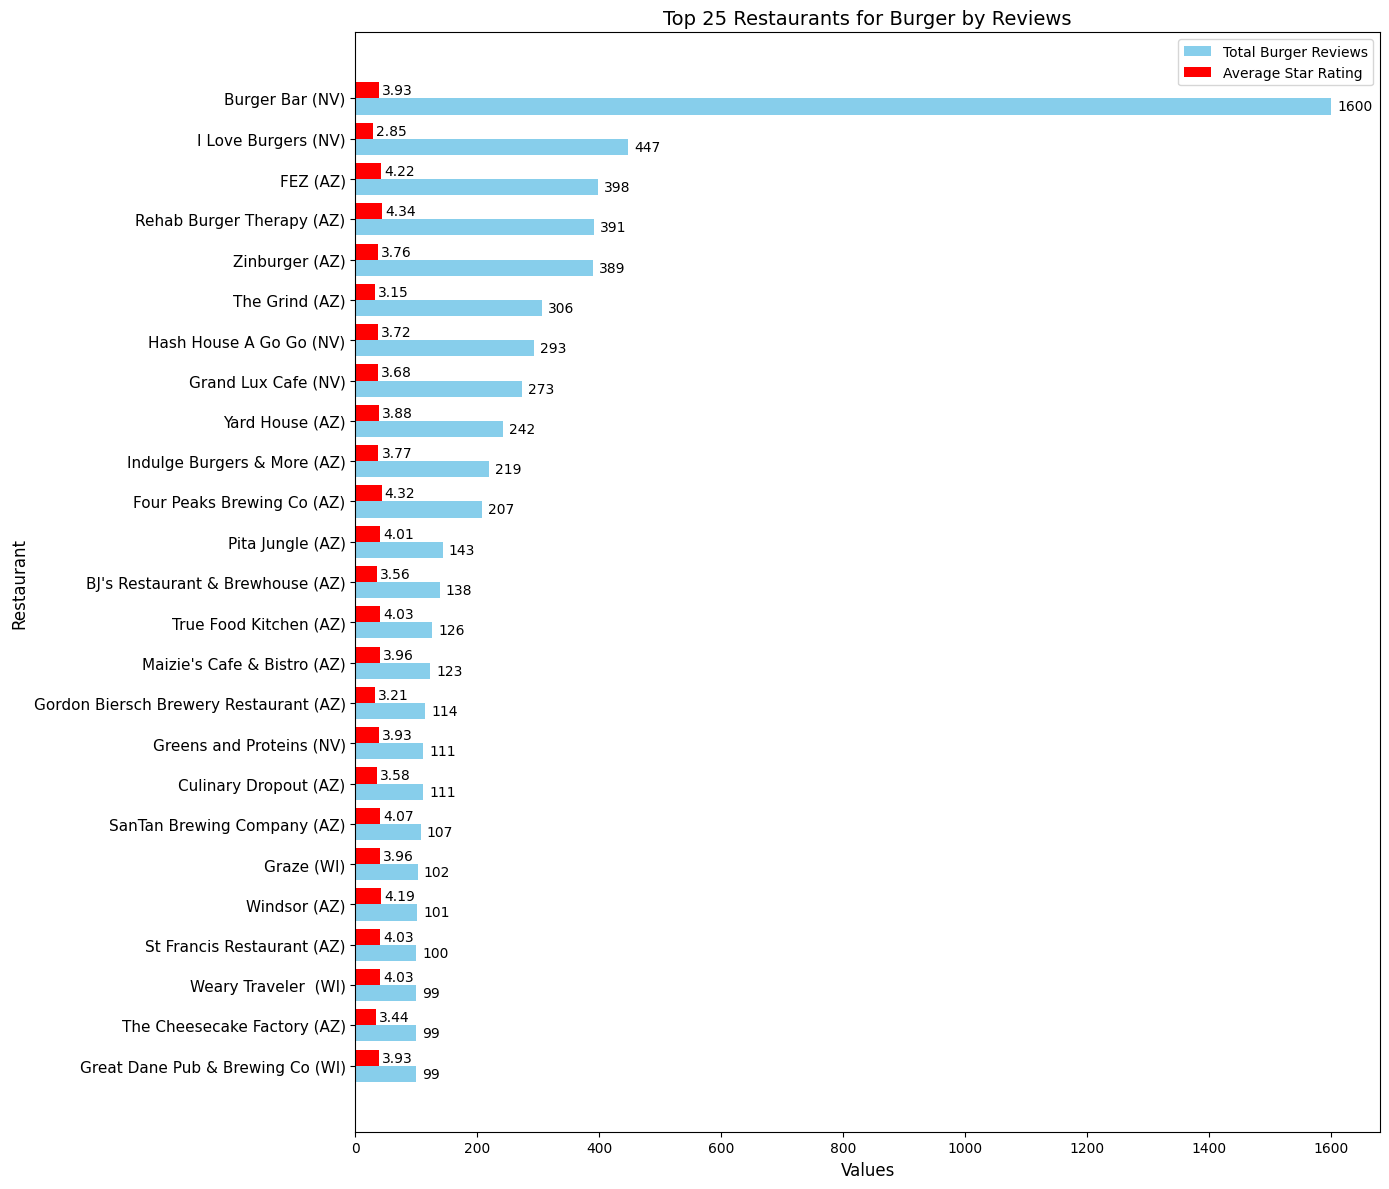

In [27]:
sorted_burger_df = viz_final_df_with_burger.sort_values(by='burger_total_reviews', ascending=False).head(25)

# Extract variables from the sorted DataFrame
restaurants = sorted_burger_df['name'].values[::-1]  # Reverse the order
states = sorted_burger_df['state'].values[::-1]
total_reviews = sorted_burger_df['burger_total_reviews'].values[::-1]
avg_ratings = sorted_burger_df['burger_average_rating'].values[::-1]

# Concatenate restaurant names with states
y_labels = [f"{name} ({state})" for name, state in zip(restaurants, states)]

ypos = np.arange(len(restaurants))
fig, ax = plt.subplots(figsize=(14, 12))
ax.barh(ypos, total_reviews, color='skyblue', height=0.4, label='Total Burger Reviews')
ax.barh(ypos + 0.4, avg_ratings * 10, color='red', height=0.4, label='Average Star Rating')

# Add y-ticks and labels
ax.set_yticks(ypos + 0.2)
ax.set_yticklabels(y_labels, fontsize=11)
ax.set_ylabel('Restaurant', fontsize=12)
ax.set_xlabel('Values', fontsize=12)
ax.set_title('Top 25 Restaurants for Burger by Reviews', fontsize=14)
ax.legend(loc='upper right')

# Add annotations for total reviews and average ratings
for i, (total, avg) in enumerate(zip(total_reviews, avg_ratings)):
    ax.text(total + 10, i, f'{total}', va='center', fontsize=10, color='black')
    ax.text(avg * 10 + 5, i + 0.4, f'{avg:.2f}', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

In [28]:
# Filter reviews that mention "chicken" for visualization
viz_chicken_reviews_df = filtered_reviews_df[filtered_reviews_df['text'].str.contains('chicken', case=False, na=False)]

# Calculate the average rating for each restaurant based only on "chicken" mentions
chicken_ratings_df = viz_chicken_reviews_df.groupby('business_id').agg(
    chicken_total_stars=pd.NamedAgg(column='stars', aggfunc='sum'),
    chicken_total_reviews=pd.NamedAgg(column='stars', aggfunc='count')
).reset_index()

# Compute the average rating for "chicken" mentions
chicken_ratings_df['chicken_average_rating'] = round(chicken_ratings_df['chicken_total_stars'] / chicken_ratings_df['chicken_total_reviews'], 2)
viz_final_df_with_chicken = pd.merge(filtered_businesses, chicken_ratings_df[['business_id', 'chicken_total_reviews', 'chicken_average_rating']], on='business_id', how='inner')
viz_final_df_with_chicken = viz_final_df_with_chicken.groupby('name').agg({
    'state': 'first',
    'review_count': 'sum',
    'chicken_total_reviews': 'sum',
    'chicken_average_rating': 'mean'
}).reset_index()
viz_final_df_with_chicken

,name,state,review_count,chicken_total_reviews,chicken_average_rating
0,101 Bistro,AZ,7,1,4.00
1,1130 The Restaurant,AZ,107,17,3.00
2,12 East Cafe,AZ,10,1,5.00
3,17 South Booze & Bites,NV,6,2,3.50
4,1855 Saloon and Grill,WI,25,8,2.75
...,...,...,...,...,...
719,ZuZu at Hotel Valley Ho,AZ,202,17,3.53
720,Zulu Caffe,AZ,59,5,4.40
721,de la Cruz Bistro,AZ,58,14,3.36
722,eat.,NV,650,156,4.06


In [29]:
viz_final_df_with_chicken.sort_values(by=['chicken_total_reviews'], ascending=False).head(20)

,name,state,review_count,chicken_total_reviews,chicken_average_rating
291,Hash House A Go Go,NV,4204,1810,3.783333
456,Pita Jungle,AZ,2291,691,4.007143
269,Grand Lux Cafe,NV,2300,591,3.796667
711,Yard House,AZ,1885,357,3.975000
598,The Cheesecake Factory,AZ,1211,300,3.687500
167,Culinary Dropout,AZ,1077,237,3.793333
44,BJ's Restaurant & Brewhouse,AZ,1137,218,3.691429
175,DW Bistro,NV,579,214,4.360000
300,Honey Salt,NV,496,167,3.950000
221,FEZ,AZ,1046,160,4.180000


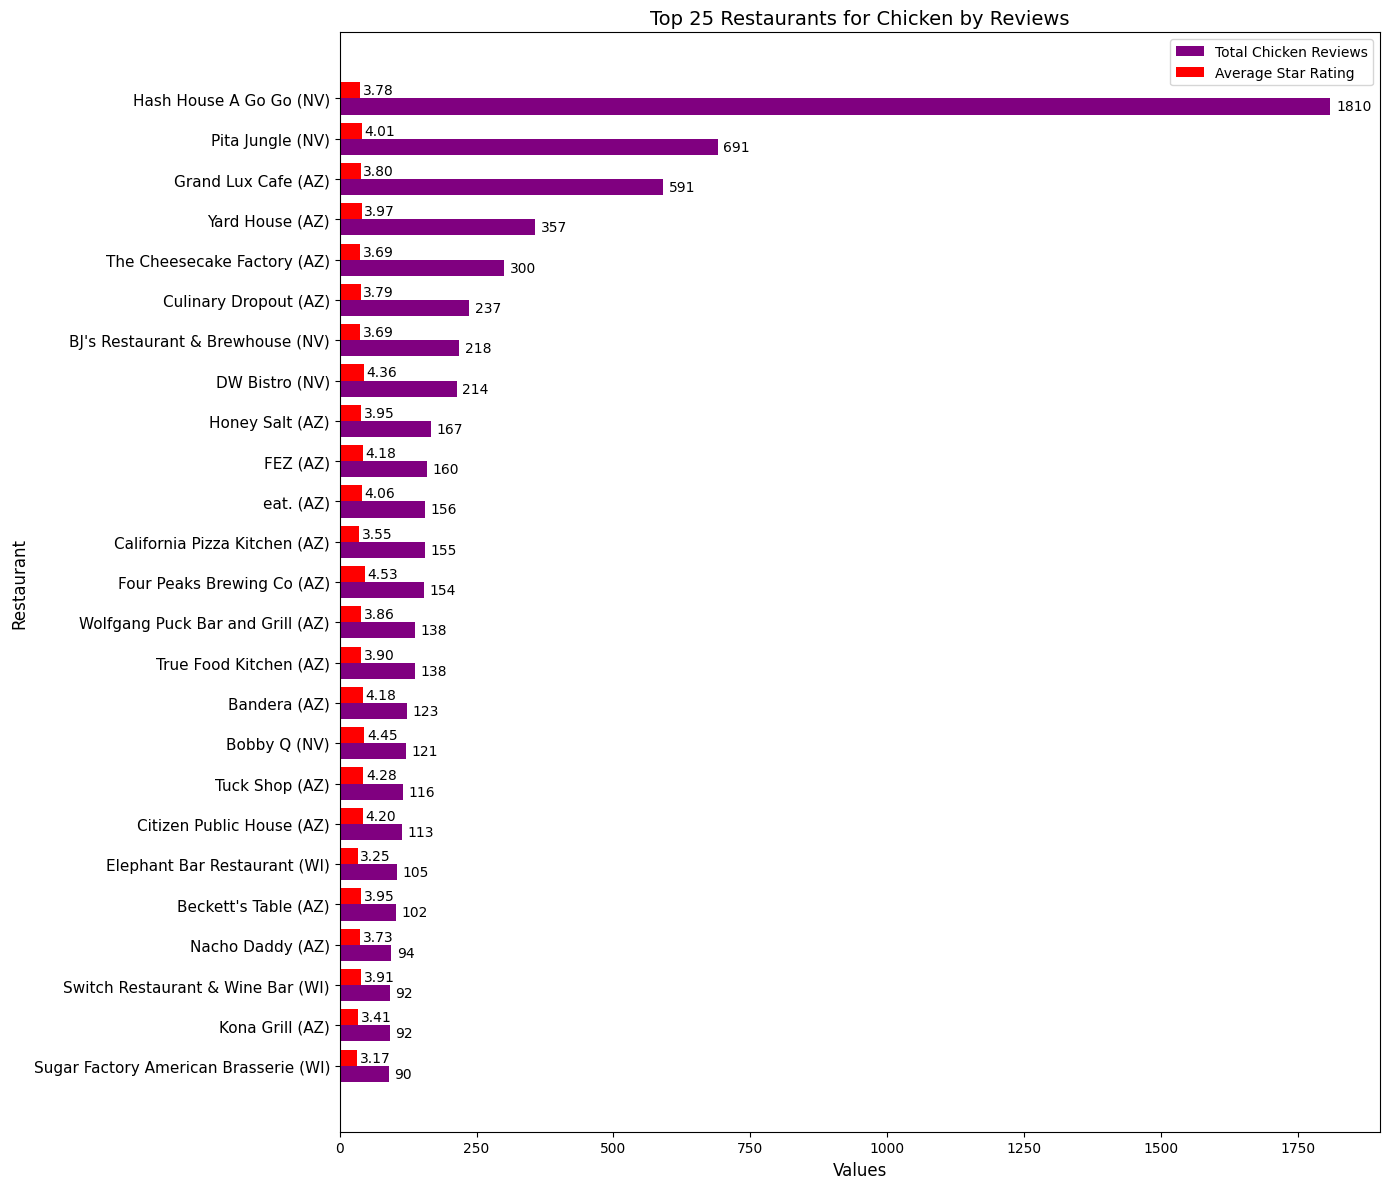

In [30]:
sorted_chicken_df = viz_final_df_with_chicken.sort_values(by='chicken_total_reviews', ascending=False).head(25)

# Extract variables from the sorted DataFrame
chicken_restaurants = sorted_chicken_df['name'].values[::-1]  # Reverse the order
chicken_total_reviews = sorted_chicken_df['chicken_total_reviews'].values[::-1]
chicken_avg_ratings = sorted_chicken_df['chicken_average_rating'].values[::-1]

# Concatenate restaurant names with states
chicken_y_labels = [f"{name} ({state})" for name, state in zip(chicken_restaurants, states)]

ypos = np.arange(len(chicken_restaurants))
fig, ax = plt.subplots(figsize=(14, 12))
ax.barh(ypos, chicken_total_reviews, color='purple', height=0.4, label='Total Chicken Reviews')
ax.barh(ypos + 0.4, chicken_avg_ratings * 10, color='red', height=0.4, label='Average Star Rating')

# Add y-ticks and labels
ax.set_yticks(ypos + 0.2)
ax.set_yticklabels(chicken_y_labels, fontsize=11)
ax.set_ylabel('Restaurant', fontsize=12)
ax.set_xlabel('Values', fontsize=12)
ax.set_title('Top 25 Restaurants for Chicken by Reviews', fontsize=14)
ax.legend(loc='upper right')

# Add annotations for total reviews and average ratings
for i, (total, avg) in enumerate(zip(chicken_total_reviews, chicken_avg_ratings)):
    ax.text(total + 10, i, f'{total}', va='center', ha='left', fontsize=10, color='black')
    ax.text(avg * 10 + 5, i + 0.4, f'{avg:.2f}', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()